In [18]:
# Import Libraries
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

In [28]:
# Generate universe variables
lin_exe_dur = ctrl.Antecedent(np.arange(0, 1200, 0.01), 'linear_execution_duration') # Milliseconds
parr_exe_dur = ctrl.Antecedent(np.arange(0,1200, 0.01), 'parallel_execution_duration') # Milliseconds
data_size_in = ctrl.Antecedent(np.arange(0,30,0.01), 'data_size_in') # Megabytes
data_throughput_in = ctrl.Antecedent(np.arange(0,850,0.01), 'data_throughput_in') # Megabits per second
data_throughput_out = ctrl.Antecedent(np.arange(0,850,0.01), 'data_throughput_out') # Megabits per second
net_latency = ctrl.Antecedent(np.arange(0,250,0.01), 'network_latency') # Milliseconds
net_bandwidth = ctrl.Antecedent(np.arange(0,500,0.01), 'network_bandwidth') # Megabits Per Seconds
realtime_priority = ctrl.Antecedent(np.arange(0,1,0.0001), 'realtime_priority') # Human chosen value from 0-1, where 1 mean requires real time feedback
req_other_info = ctrl.Antecedent(np.arange(0,1,0.01), 'req_other_info')  # Binary 0 or 1 for if it requires other's info

cloud = ctrl.Consequent(np.arange(0, 1, 0.01), 'cloud') # Probablity from 0-1 that container should be on the cloud
edge = ctrl.Consequent(np.arange(0, 1, 0.01), 'edge') # Probablity from 0-1 that container should be on the edge
end_device = ctrl.Consequent(np.arange(0, 1, 0.01), 'end_device') # Probablity from 0-1 that container should be on the end device

In [29]:
# Generate fuzzy membership functions
lin_exe_dur['low'] = fuzz.trapmf(lin_exe_dur.universe, [0, 0, 200, 400])
lin_exe_dur['medium'] = fuzz.gaussmf(lin_exe_dur.universe, 500, 100)
lin_exe_dur['high'] = fuzz.trapmf(lin_exe_dur.universe, [600, 1000, 60000, 60000])

parr_exe_dur['low'] = fuzz.trapmf(parr_exe_dur.universe, [0, 0, 200, 400])
parr_exe_dur['medium'] = fuzz.gaussmf(parr_exe_dur.universe, 500, 100)
parr_exe_dur['high'] = fuzz.trapmf(parr_exe_dur.universe, [600, 1000, 60000, 60000])

data_throughput_in['low'] = fuzz.trapmf(data_throughput_in.universe, [0, 0, 40,120])
data_throughput_in['medium'] = fuzz.gaussmf(data_throughput_in.universe, 250,100)
data_throughput_in['high'] = fuzz.trapmf(data_throughput_in.universe, [400, 800,2500,2500])

data_throughput_out['low'] = fuzz.trapmf(data_throughput_out.universe, [0, 0, 40, 120])
data_throughput_out['medium'] = fuzz.gaussmf(data_throughput_out.universe, 250, 100)
data_throughput_out['high'] = fuzz.trapmf(data_throughput_out.universe, [400,800,2500,2500])

net_latency['low'] = fuzz.trapmf(net_latency.universe, [0, 0, 25, 50])
net_latency['medium'] = fuzz.gaussmf(net_latency.universe, 75, 25)
net_latency['high'] = fuzz.trapmf(net_latency.universe, [100, 200,500,500])

net_bandwidth['low'] = fuzz.trapmf(net_bandwidth.universe, [0, 0, 25,75])
net_bandwidth['medium'] = fuzz.gaussmf(net_bandwidth.universe, 150,25)
net_bandwidth['high'] = fuzz.trapmf(net_bandwidth.universe, [200, 300,1000,1000])

realtime_priority['low'] = fuzz.trapmf(realtime_priority.universe, [0, 0, .25,.5])
realtime_priority['medium'] = fuzz.gaussmf(realtime_priority.universe, 0.5,0.15)
realtime_priority['high'] = fuzz.trapmf(realtime_priority.universe, [0.5, 0.75,1.0,1.0])

req_other_info['no'] = fuzz.trapmf(req_other_info.universe, [0, 0, 0.500,0.500])
req_other_info ['yes'] = fuzz.trapmf(req_other_info.universe, [0.500, 0.500,1.0,1.0])

cloud['low'] = fuzz.trapmf(cloud.universe, [0, 0, .25,.5])
cloud['medium'] = fuzz.gaussmf(cloud.universe, 0.5,0.15)
cloud['high'] = fuzz.trapmf(cloud.universe, [0.5, 0.75,1.0,1.0])

edge['low'] = fuzz.trapmf(edge.universe, [0, 0, .25,.5])
edge['medium'] = fuzz.gaussmf(edge.universe, 0.5,0.15)
edge['high'] = fuzz.trapmf(edge.universe, [0.5, 0.75,1.0,1.0])

end_device['low'] = fuzz.trapmf(end_device.universe, [0, 0, .25,.5])
end_device['medium'] = fuzz.gaussmf(end_device.universe, 0.5,0.15)
end_device['high'] = fuzz.trapmf(end_device.universe, [0.5, 0.75,1.0,1.0])

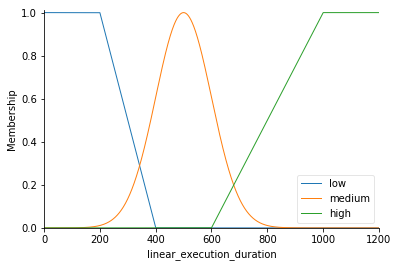

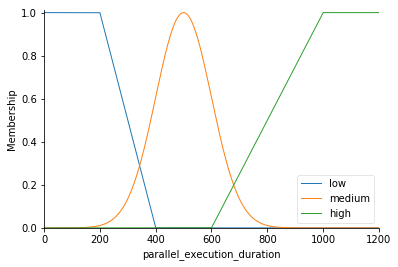

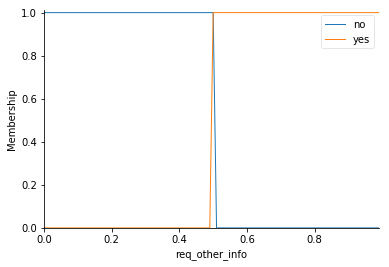

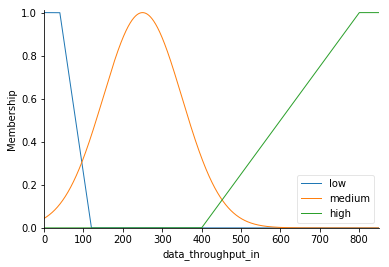

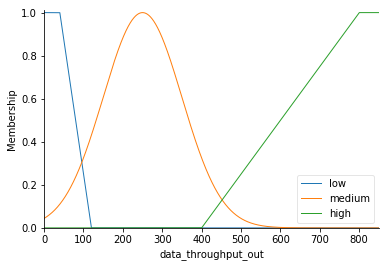

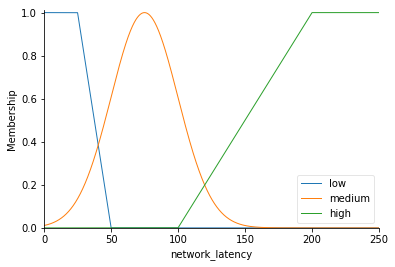

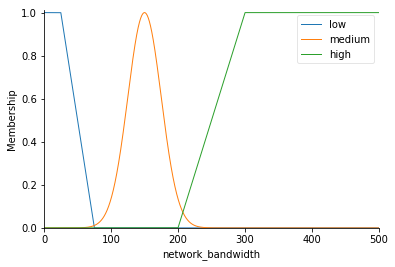

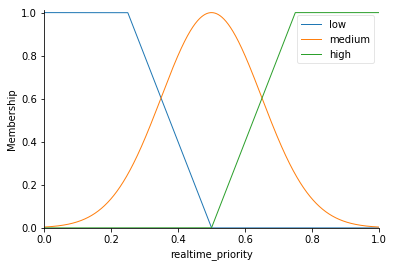

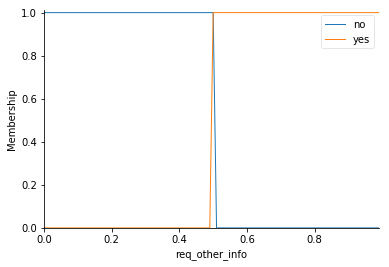

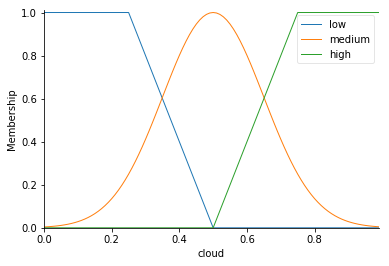

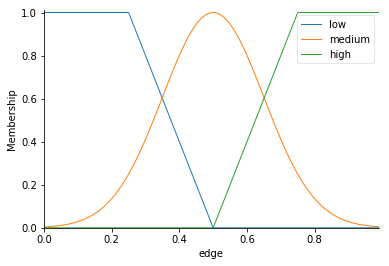

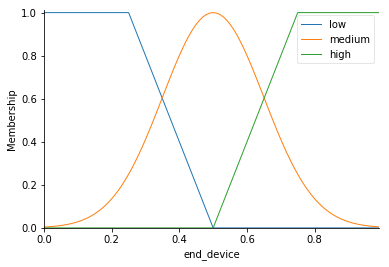

In [30]:
# Visualize these universes and membership functions
lin_exe_dur.view()
parr_exe_dur.view()
req_other_info.view()
data_throughput_in.view()
data_throughput_out.view()
net_latency.view()
net_bandwidth.view()
realtime_priority.view()
req_other_info.view()
cloud.view()
edge.view()
end_device.view()
plt.show()